#**XGBoost**
---
##Author: Emmanuel Paalam
##V4: MICE processing
##Target variable: F3EVERDO

## Import data

In [1]:
import pandas as pd
from google.colab import drive

drive.mount("/content/drive")
## Insert pathway to dataset below
df = pd.read_csv("/content/drive/My Drive/research/SURP 2024/colab/data/processed/epaalam-MICEprocessed_els_02_12_byf3pststu_v1_0.csv")

df.dropna(inplace=True)

Mounted at /content/drive


In [2]:
df.shape

(13119, 212)

## Split data

In [3]:
y = df['F3EVERDO']
y.shape

(13119,)

In [4]:
X = df.drop(columns='F3EVERDO', axis=1)
X.shape

(13119, 211)

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=58, stratify=y)
print(f"{X_train.shape}, {X_test.shape}, {y_train.shape}, {y_test.shape}")

(10495, 211), (2624, 211), (10495,), (2624,)


##Model development

In [6]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix

In [12]:
param_grid = {
    'learning_rate': [0.05],
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 6, 9],
    'min_child_weight': [1, 3, 5]
}

In [13]:
def specificity_score(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return tn / (tn + fp)

def npv_score(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return tn / (tn + fn)

In [14]:
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score, accuracy_score

scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score, average='macro'),
    'recall': make_scorer(recall_score, average='macro'),
    'f1': make_scorer(f1_score, average='macro'),
    'specificity': make_scorer(specificity_score),
    'npv': make_scorer(npv_score)
}

In [15]:
from sklearn.model_selection import StratifiedKFold

grid_search = GridSearchCV(xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss'), param_grid=param_grid,
                           scoring=scoring, refit='f1', cv=StratifiedKFold(n_splits=5), verbose=1, n_jobs=-1)

In [16]:
grid_search.fit(X_train, y_train)

# Access and print the cv_results_
results = grid_search.cv_results_

Fitting 5 folds for each of 27 candidates, totalling 135 fits


In [17]:
import numpy as np

# Print the relevant metrics
print("Mean Test Accuracy:", np.mean(results['mean_test_accuracy']))
print("Mean Test Precision:", np.mean(results['mean_test_precision']))
print("Mean Test Recall:", np.mean(results['mean_test_recall']))
print("Mean Test F1:", np.mean(results['mean_test_f1']))
print("Mean Test Specificity:", np.mean(results['mean_test_specificity']))
print("Mean Test NPV:", np.mean(results['mean_test_npv']))

Mean Test Accuracy: 0.9547474105835231
Mean Test Precision: 0.909243868633212
Mean Test Recall: 0.8303884701050543
Mean Test F1: 0.8642065439797698
Mean Test Specificity: 0.986895229041576
Mean Test NPV: 0.9635662369608861


In [18]:
# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best parameters found: ", best_params)
print("Best cross-validation score: {:.2f}".format(best_score))

Best parameters found:  {'learning_rate': 0.05, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 300}
Best cross-validation score: 0.87


### Observe metrics

Accuracy: 0.9554115853658537
Precision: 0.8311688311688312
Recall: 0.7111111111111111
F1 Score: 0.7664670658682636
ROC-AUC: 0.970735391296139
Specificity: 0.9834324553950722
Test Negative Predictive Value (NPV): 0.9674049310488926
Confusion Matrix:
[[2315   39]
 [  78  192]]


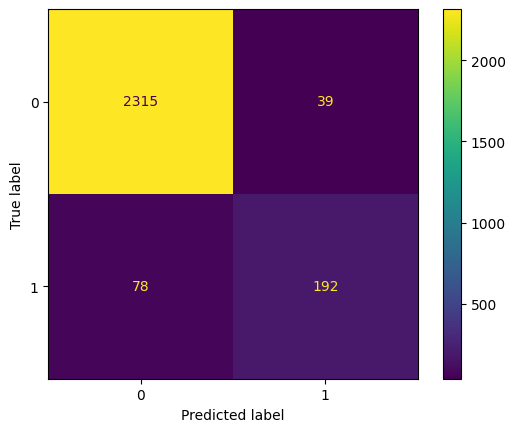

In [19]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, roc_curve, ConfusionMatrixDisplay

# Retrieve the best model
best_model = grid_search.best_estimator_

# Predict on the test set
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]  # Probability estimates for the positive class

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

# Calculate specificity
tn, fp, fn, tp = conf_matrix.ravel()
specificity = tn / (tn + fp)

# Calculate test negative predictive value (NPV)
test_npv = tn / (tn + fn)

# Print the metrics
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"ROC-AUC: {roc_auc}")
print(f"Specificity: {specificity}")
print(f'Test Negative Predictive Value (NPV): {test_npv}')
print("Confusion Matrix:")
print(conf_matrix)

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=best_model.classes_)
disp.plot()